# Limpieza

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

In [2]:
datos = pd.read_csv('dataset/final-train.csv')
datos.head()

,Summary,Text,Score
0,Can really notice when I am not drinking it,I have had hormone problems in the past couple...,5
1,"Okay, just not the best",This is a decent balsamic glaze/reducation.<br...,4
2,"goo source of fiber, not so much a source of c...",the cookie is moist and chewy and has a great ...,3
3,Great GF Staple,I have a 4 yr old and a 2 yr old that can't ea...,5
4,Coffee just doesn't taste right without Sweet ...,We have drunk our coffee for 45 years using th...,5


In [3]:
# Vemos la primera entrada de la columna 'text' y la columna 'summary'
print(datos['Text'][1])

This is a decent balsamic glaze/reducation.<br /><br />It has a faint yeasty taste that I don't care for...not so heavy to preclude using it again, but I have a different brand that I love love love, so this is just a back up.<br /><br />FYI try Blaze balsamic reduction/glaze.  It is superb.


In [4]:
print(datos['Summary'][0])

Can really notice when I am not drinking it


In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  426323 non-null  object
 1   Text     426340 non-null  object
 2   Score    426340 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.8+ MB


In [6]:
def limpiar_datos(dataframe):
    dataframe = dataframe.copy().dropna()
    dataframe['FullText'] = dataframe['Summary'] + ' ' + dataframe['Text']
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'<.*?>', '', regex=True)
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'\d+', '', regex=True)
    dataframe['FullText'] = dataframe['FullText'].str.replace(r'[^\w\s]', ' ', regex=True).str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

    dataframe = dataframe[['FullText','Score']]

    return dataframe

In [7]:
datos_limpio = limpiar_datos(datos)

In [8]:
print(datos_limpio['FullText'][1])

okay best decent balsamic glaze reducation faint yeasty taste care heavy preclude using different brand love love love back fyi try blaze balsamic reduction glaze superb


In [9]:
datos_limpio.head()

,FullText,Score
0,really notice drinking hormone problems past c...,5
1,okay best decent balsamic glaze reducation fai...,4
2,goo source fiber much source chocoate cookie m...,3
3,great gf staple yr old yr old eat gluten aweso...,5
4,coffee taste right without sweet n low drunk c...,5


## Entrenamiento

In [10]:
map_dict = {1: 0, 2:0, 3:1, 4:1, 5:1}

datos_limpio['Label'] = datos_limpio['Score'].map(map_dict)
datos_limpio.sample(10)

,FullText,Score,Label
136260,excellent product color hair always loved cond...,5,1
265344,delicious hot sauce first discovered huy fong ...,5,1
378725,sambazon acai powerscoop got product time perf...,5,1
367942,great gift party great gift party dark chocola...,5,1
12368,nice taste everyday usually fan flavored coffe...,4,1
165120,good coffee great price good coffee great pric...,5,1
219923,started okay became lost cause one four five v...,3,1
183044,girls go wild zuke dog treats two girls love t...,5,1
346350,refreshing organic tea tried several ambassado...,5,1
218047,lychee gummies gummies great bought mom ate pr...,4,1


<Axes: ylabel='Frequency'>

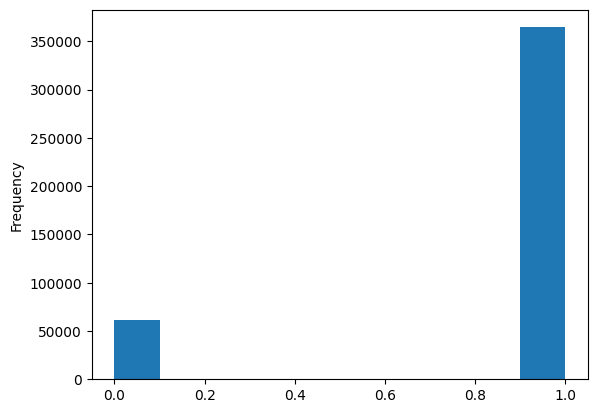

In [11]:
datos_limpio['Label'].plot(kind='hist')

In [12]:
datos_pos = datos_limpio[datos_limpio['Label'] == 1].sample(100000)
datos_neg = datos_limpio[datos_limpio['Label'] == 0]

In [13]:
datos_recortados = pd.concat([datos_neg, datos_pos], ignore_index=True, sort=False)

<Axes: ylabel='Frequency'>

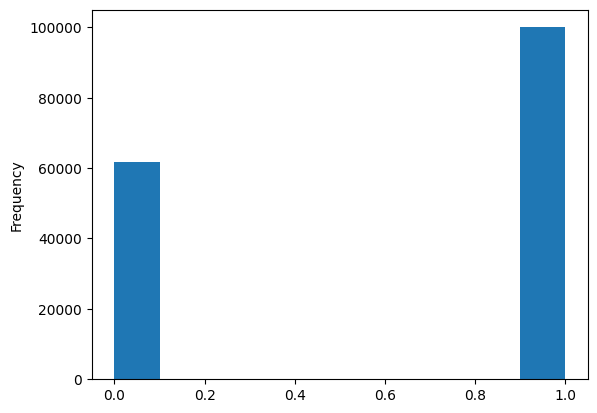

In [14]:
datos_recortados['Label'].plot(kind='hist')

285.89907031945404


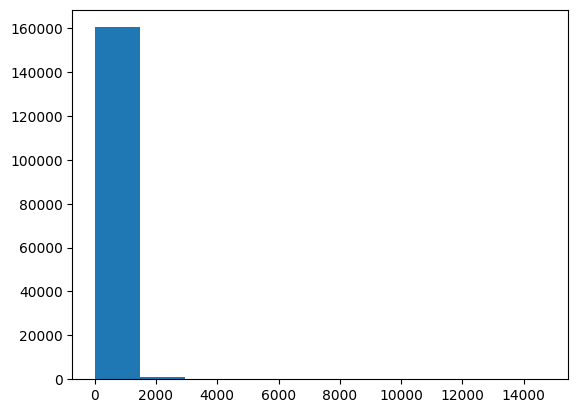

In [15]:
str_lengths = []
for row in datos_recortados['FullText']:
    str_lengths.append(len(row))

print(np.mean(str_lengths))
plt.hist(str_lengths)
plt.show()

### Entrenando un modelo de machine learning (NB)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(datos_recortados['FullText'], datos_recortados['Label'], test_size=0.3, random_state=42, stratify=datos_recortados['Label'])
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [17]:
tfidf = TfidfVectorizer(max_features=None)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [18]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [19]:
y_pred = nb_classifier.predict(X_test_tfidf)

In [20]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.64      0.75     18533
           1       0.81      0.96      0.88     30000

    accuracy                           0.84     48533
   macro avg       0.86      0.80      0.82     48533
weighted avg       0.85      0.84      0.83     48533



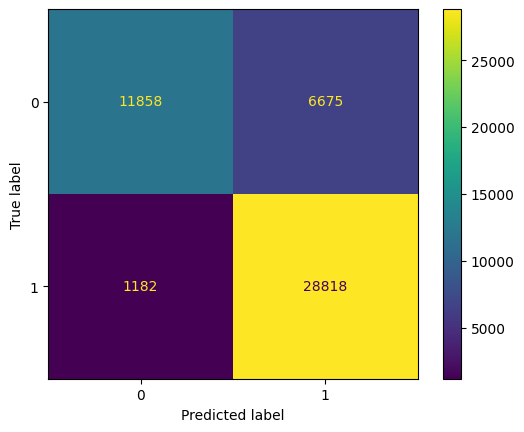

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()

### Entrenando un modelo tipo BERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device('cuda')

tokenizer = AutoTokenizer.from_pretrained('albert/albert-base-v2')

AttributeError: 'AlbertTokenizerFast' object has no attribute 'to'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datos_recortados['FullText'], datos_recortados['Label'], test_size=0.3, random_state=42, stratify=datos_recortados['Label'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

: 

In [ ]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)